In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Data/Mall_Customers.csv", sep=',')

In [3]:
df.shape

(200, 5)

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

## Análise exploratória dos dados

In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].median()

Age                       36.0
Annual Income (k$)        61.5
Spending Score (1-100)    50.0
dtype: float64

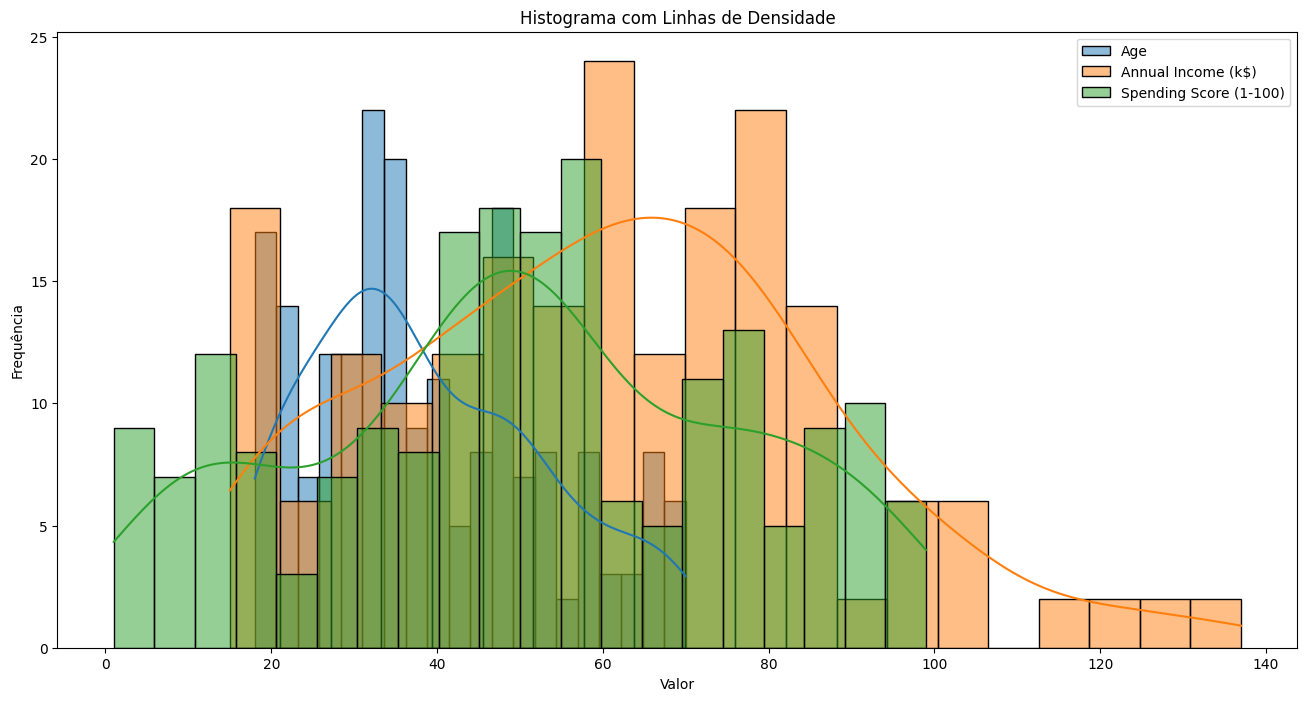

In [9]:
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(16, 8))
for column in selected_columns:
    sns.histplot(data=df, x=column, kde=True, bins=20, label=column) # type: ignore

plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Histograma com Linhas de Densidade')
plt.legend()
plt.show()

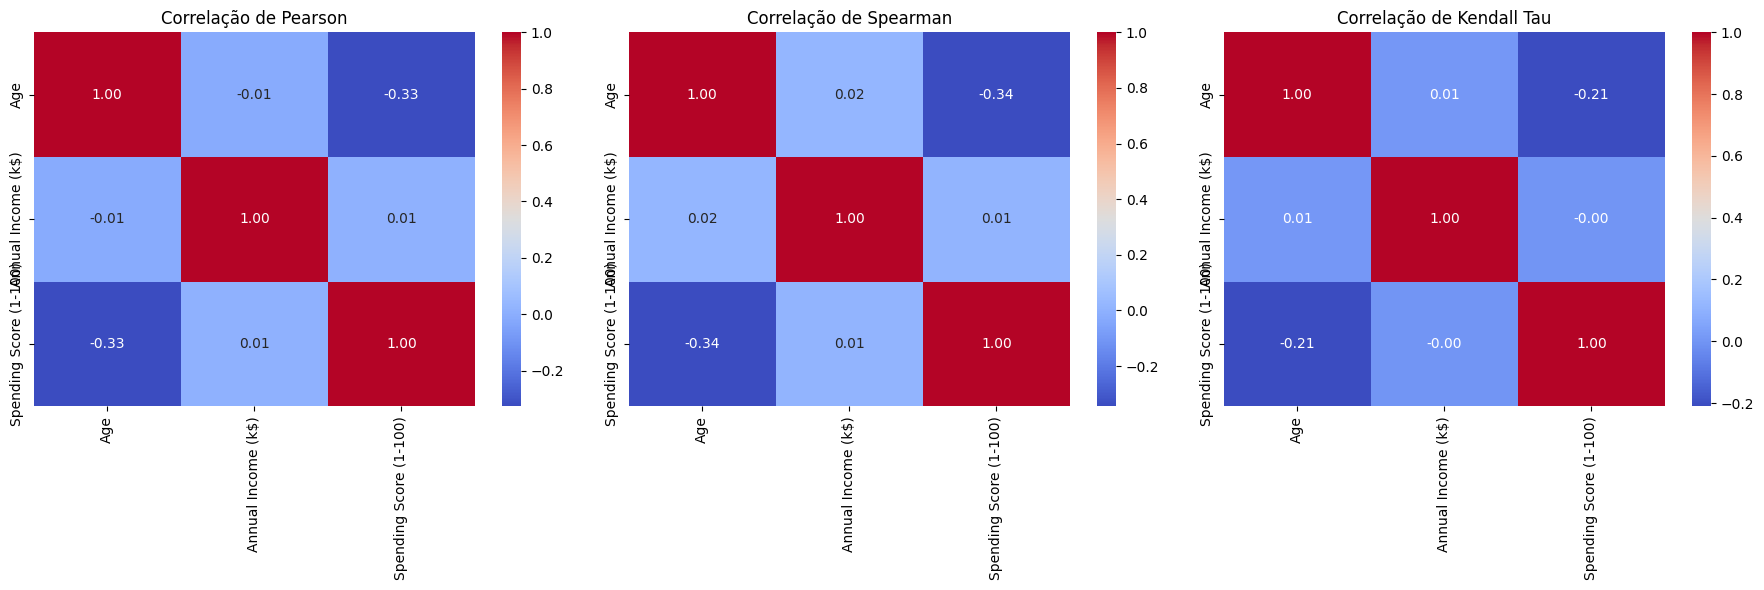

In [10]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(df[selected_columns].corr(method='pearson'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Pearson')

plt.subplot(1, 3, 2)
sns.heatmap(df[selected_columns].corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Spearman')

plt.subplot(1, 3, 3)
sns.heatmap(df[selected_columns].corr(method='kendall'), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlação de Kendall Tau')

plt.tight_layout()
plt.show()

In [11]:
df['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

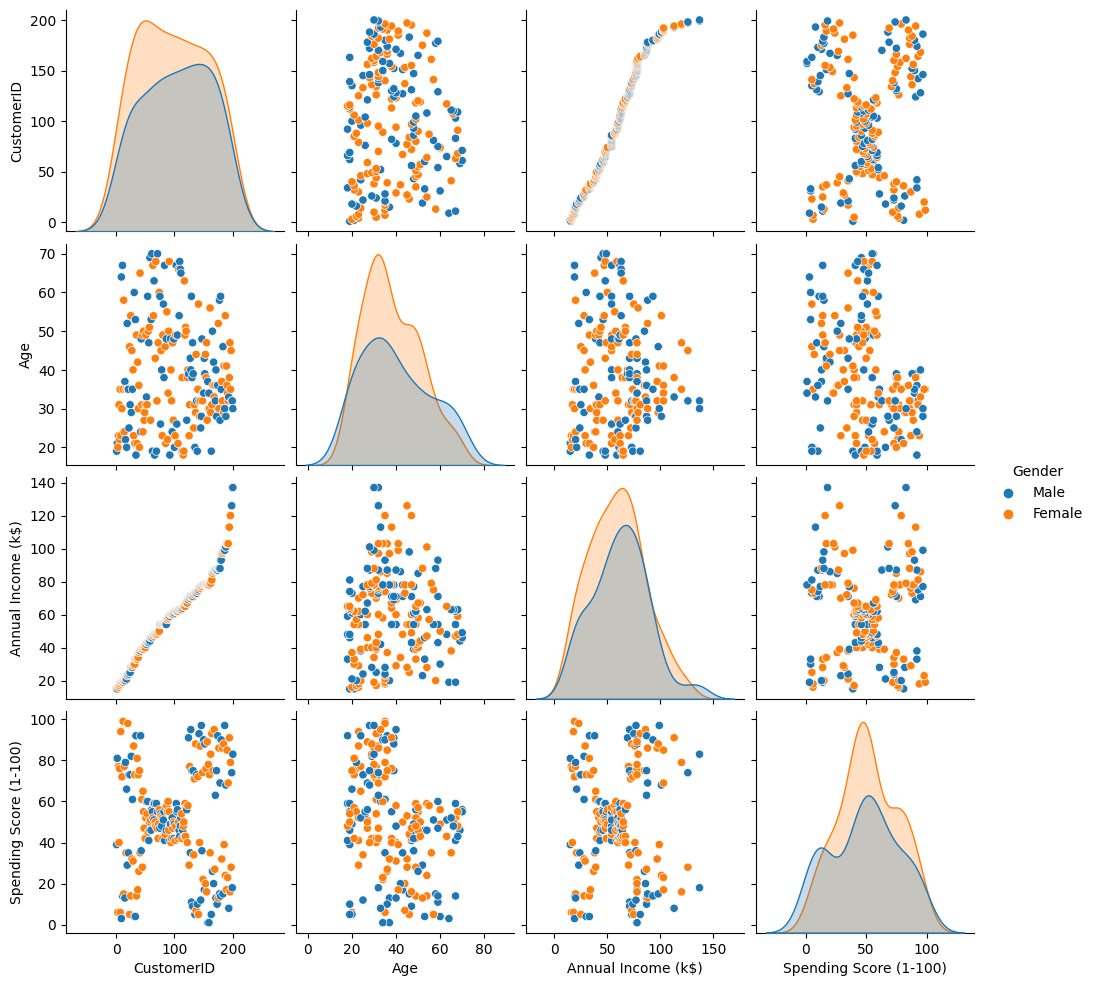

In [12]:
sns.pairplot(df, hue="Gender")
plt.show()

## Feature Scaling

In [13]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
scaler.fit(df[['Annual Income (k$)','Spending Score (1-100)']])
X_scaler = scaler.transform(df[['Annual Income (k$)','Spending Score (1-100)']])

In [14]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

### Elbow method - determinar o número apropriado de clusters.

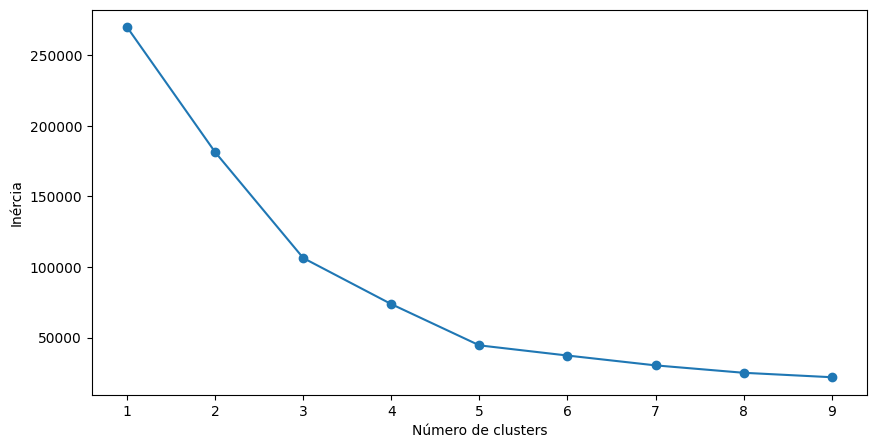

In [15]:
k = list(range(1, 10))
sse = []

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    sse.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(k, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

## K-Means

In [16]:
kmeans = KMeans(random_state=42)

param_grid = {
    'n_clusters': [5],
    'init': ['k-means++', 'random'],  # Métodos de inicialização dos centróides
    'n_init': [10, 20, 30],  # Número de inicializações diferentes
    'max_iter': [100, 200, 300],  # Número máximo de iterações
    'tol': [1e-4, 1e-5, 1e-6],  # Tolerância para convergência
    'algorithm': ['elkan', 'lloyd']  # Algoritmo K-Means
}

grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search_scaler = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)
grid_search_scaler.fit(X_scaler)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores parâmetros scaler:", grid_search_scaler.best_params_)

best_kmeans = grid_search.best_estimator_
best_kmeans_scaler = grid_search_scaler.best_estimator_

centroides = best_kmeans.cluster_centers_
centroides_scaler = best_kmeans_scaler.cluster_centers_

best_kmeans_labels = best_kmeans.predict(X)
best_kmeans_labels_scaler = best_kmeans_scaler.predict(X_scaler)

Melhores parâmetros: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'n_init': 10, 'tol': 0.0001}
Melhores parâmetros scaler: {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'n_init': 20, 'tol': 0.0001}


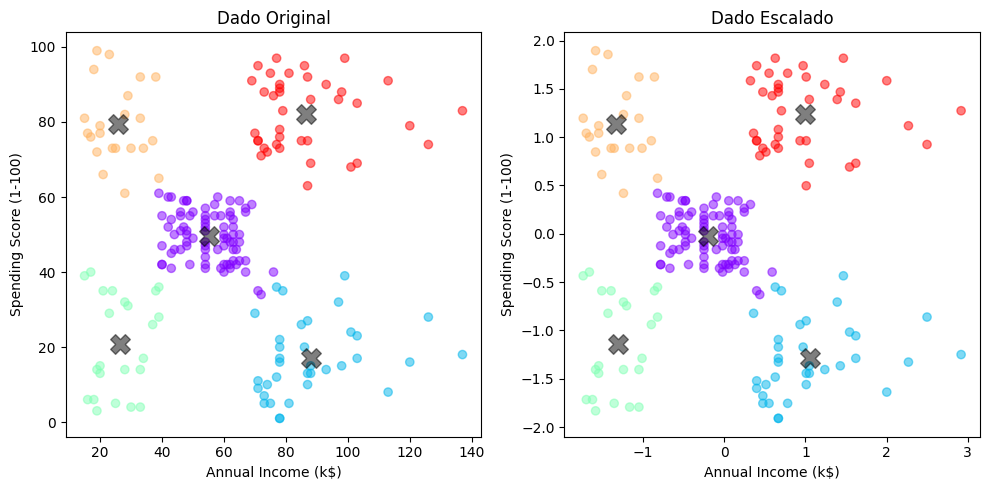

In [17]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=best_kmeans_labels, alpha=0.5, cmap='rainbow')
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5) # type: ignore
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=best_kmeans_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.scatter(centroides_scaler[:, 0], centroides_scaler[:, 1], c='black', marker='X', s=200, alpha=0.5) # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## DBScan

In [18]:
dbscan = DBSCAN(eps=10, min_samples=8, algorithm='auto')
dbscan.fit(X)
dbscan_labels = dbscan.labels_

dbscan_scaler = DBSCAN(eps=10, min_samples=8, algorithm='auto')
dbscan_scaler.fit(X_scaler)
dbscan_labels_scaler = dbscan_scaler.labels_

### Com outliers

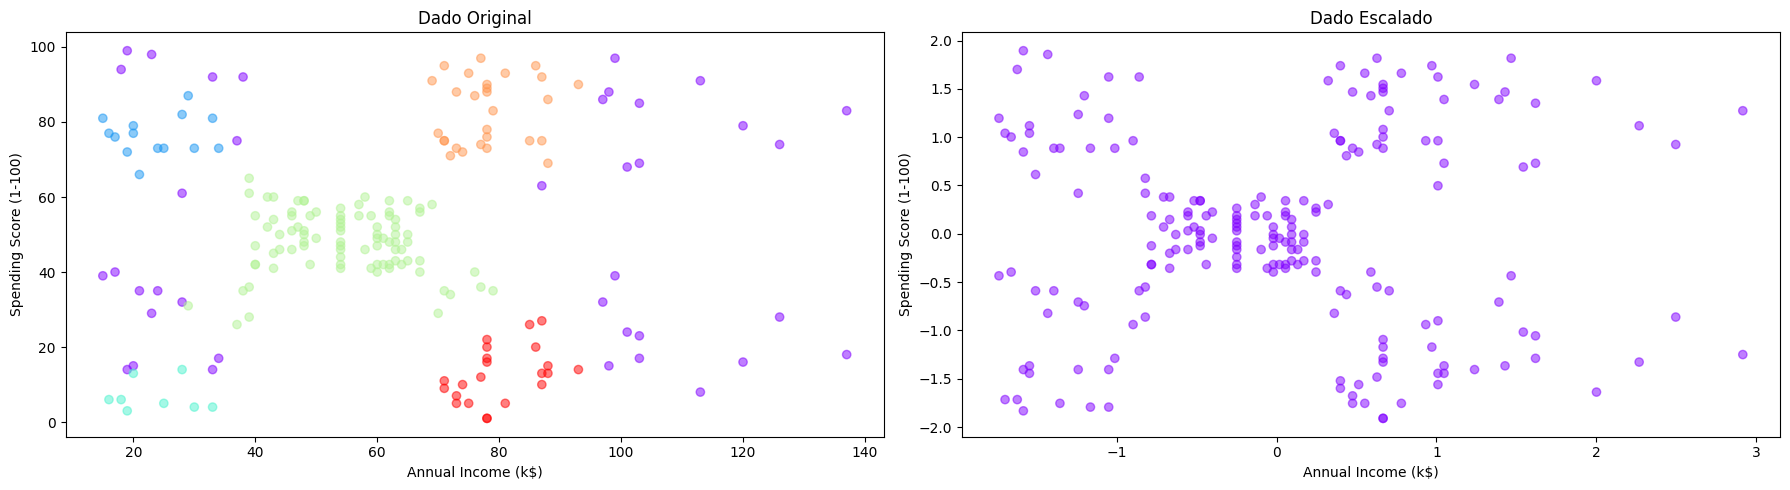

In [19]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=dbscan_labels, alpha=0.5, cmap='rainbow')
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=dbscan_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

### Sem outliers

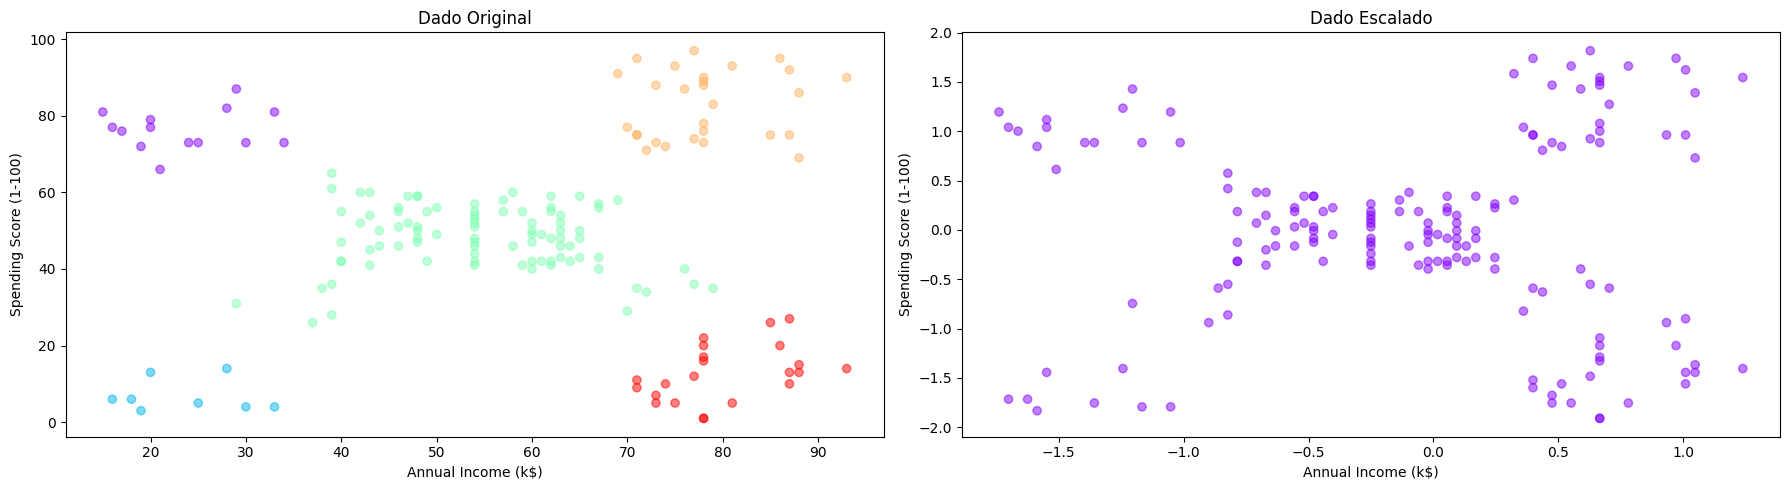

In [20]:
mascara = dbscan_labels>=0

plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']][mascara], df[['Spending Score (1-100)']][mascara], c=dbscan_labels[mascara], alpha=0.5, cmap='rainbow')
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0][mascara], X_scaler[:, 1][mascara], c=dbscan_labels_scaler[mascara], alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## Gaussian Mixture

In [21]:
gmm = GaussianMixture(random_state=42)

param_grid = {
    'n_components': [2, 3, 4, 5],  # Teste diferentes números de componentes
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de matriz de covariância
    'max_iter': [50, 100, 200],  # Número máximo de iterações
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerância para convergência
}

grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search_scaler = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search.fit(X)
grid_search_scaler.fit(X_scaler)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores parâmetros scaler:", grid_search_scaler.best_params_)

best_gmm = grid_search.best_estimator_
best_gmm_scaler = grid_search_scaler.best_estimator_
gmm_labels = best_gmm.predict(X)
gmm_labels_scaler = best_gmm_scaler.predict(X_scaler)

Melhores parâmetros: {'covariance_type': 'spherical', 'max_iter': 50, 'n_components': 2, 'tol': 1e-05}
Melhores parâmetros scaler: {'covariance_type': 'spherical', 'max_iter': 50, 'n_components': 2, 'tol': 1e-05}


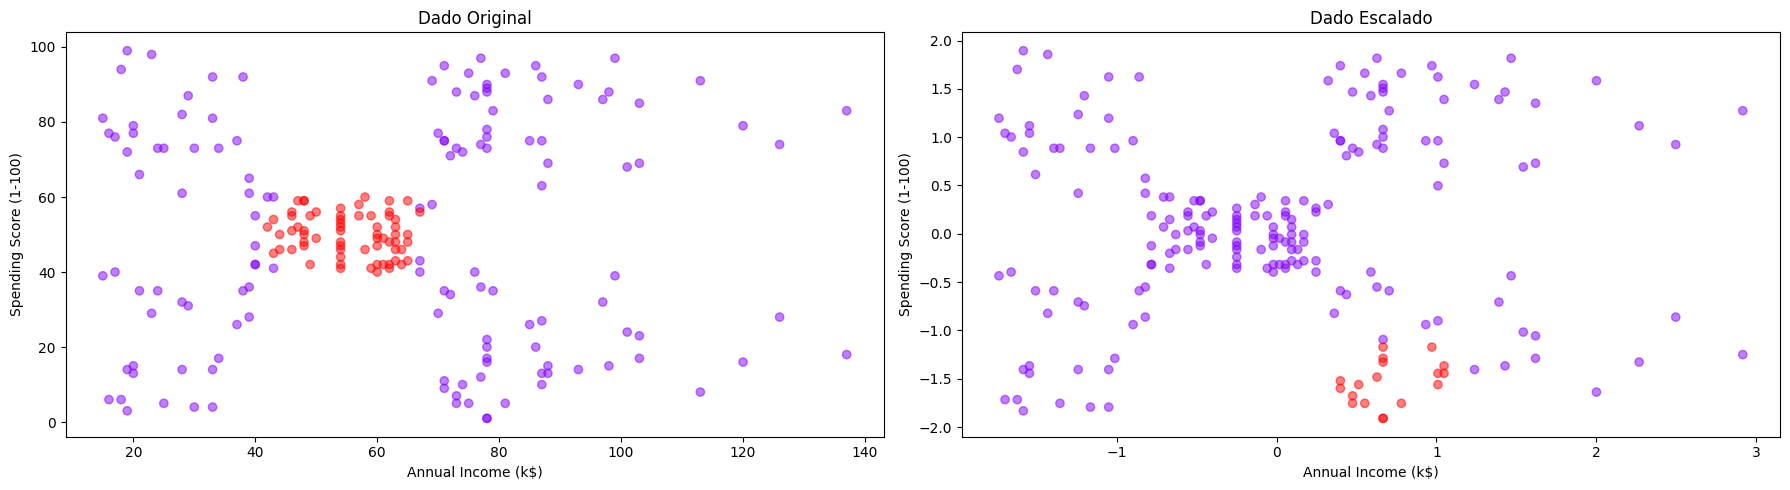

In [22]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=gmm_labels, alpha=0.5, cmap='rainbow')
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=gmm_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## Mean Shift

In [23]:
mean_shift = MeanShift()

param_grid = {
    'bandwidth': [0.1, 0.2, 0.5, 1.0, 1.5],  # Largura da banda (bandwidth)
    'cluster_all': [True, False],  # Se deve ou não criar um cluster para os pontos "outliers"
}

grid_search = GridSearchCV(estimator=mean_shift, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search_scaler = GridSearchCV(estimator=mean_shift, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(X)
grid_search_scaler.fit(X_scaler)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores parâmetros scaler:", grid_search_scaler.best_params_)

best_mean_shift = grid_search.best_estimator_
best_mean_shift_scaler = grid_search_scaler.best_estimator_
mean_shift_labels = best_mean_shift.fit_predict(X)
mean_shift_labels_scaler = best_mean_shift_scaler.fit_predict(X_scaler)

Melhores parâmetros: {'bandwidth': 1.5, 'cluster_all': True}
Melhores parâmetros scaler: {'bandwidth': 0.2, 'cluster_all': True}


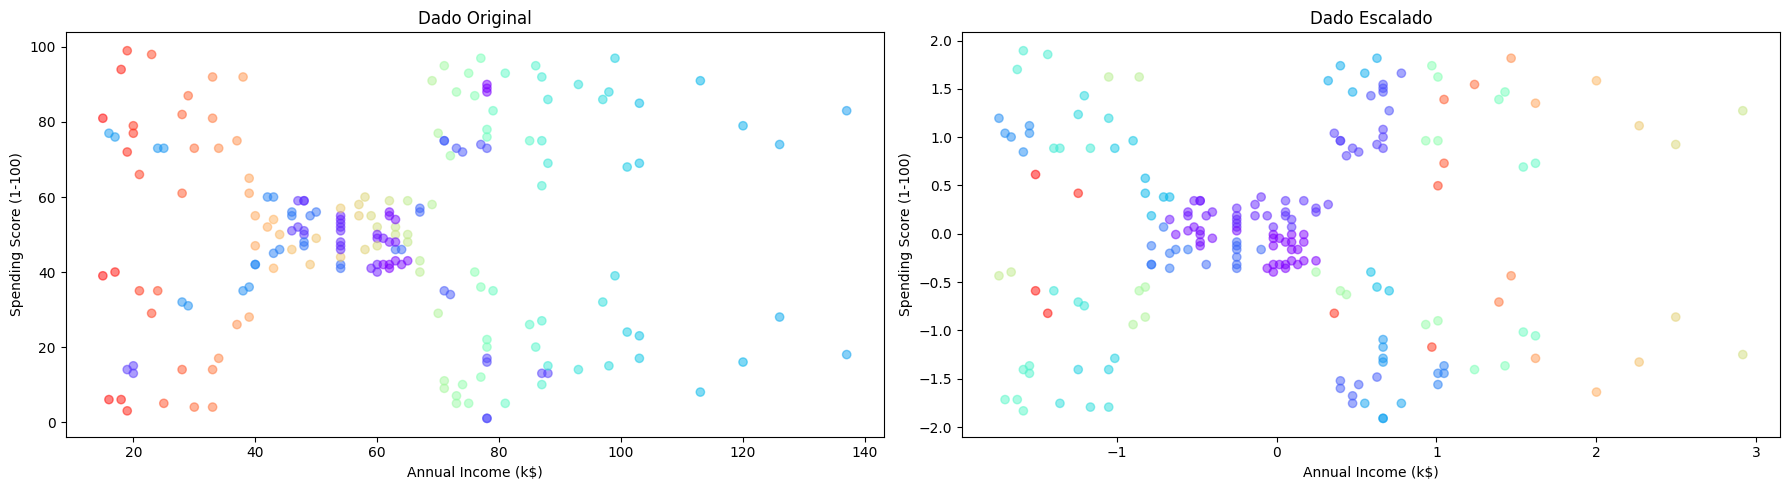

In [24]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=mean_shift_labels, alpha=0.5, cmap='rainbow')
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=mean_shift_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## Spectral Clustering

In [25]:
spectral_clustering = SpectralClustering()

param_grid = {
    'n_clusters': [2, 3, 4, 5],  # Teste diferentes números de clusters
    'affinity': ['nearest_neighbors', 'rbf'],  # Tipo de afinidade (proximidade)
    'n_neighbors': [5, 10, 15],  # Número de vizinhos para 'nearest_neighbors'
}

grid_search = GridSearchCV(estimator=spectral_clustering, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search_scaler = GridSearchCV(estimator=spectral_clustering, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(X)
grid_search_scaler.fit(X_scaler)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores parâmetros scaler:", grid_search_scaler.best_params_)

best_spectral_clustering = grid_search.best_estimator_
best_spectral_clustering_scaler = grid_search_scaler.best_estimator_
spectral_clustering_labels = best_spectral_clustering.fit_predict(X)
spectral_clustering_labels_scaler = best_spectral_clustering_scaler.fit_predict(X_scaler)

Melhores parâmetros: {'affinity': 'nearest_neighbors', 'n_clusters': 2, 'n_neighbors': 10}
Melhores parâmetros scaler: {'affinity': 'rbf', 'n_clusters': 2, 'n_neighbors': 5}


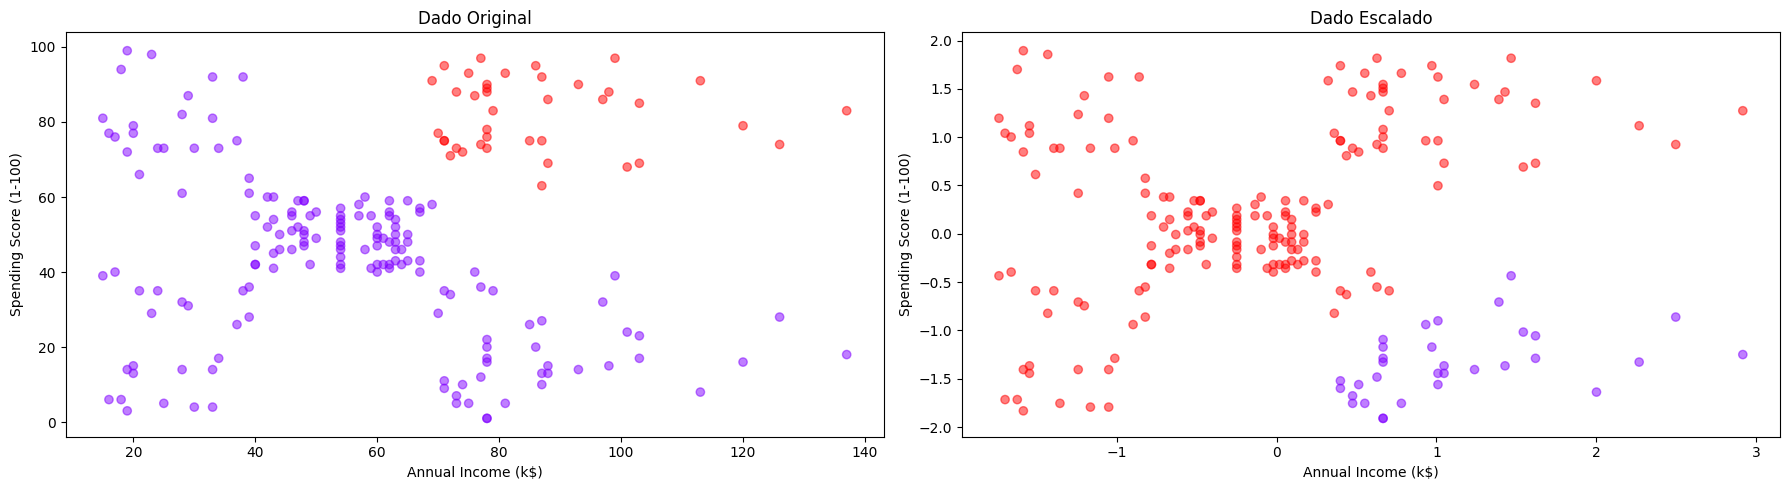

In [26]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=spectral_clustering_labels, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=spectral_clustering_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## Agglomerative Clustering

In [27]:
agg_clustering = AgglomerativeClustering()

param_grid = {
    'n_clusters': [5],
    'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'],  # Métrica de distância
    'linkage': ['ward', 'complete', 'average', 'single'],  # Critério de ligação
    'compute_full_tree': [True, False],  # Calcular a árvore completa ou não
    'distance_threshold': [None, 10, 20, 30]  # Limiar de distância para parar o agrupamento
}

grid_search = GridSearchCV(estimator=agg_clustering, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search_scaler = GridSearchCV(estimator=agg_clustering, param_grid=param_grid, cv=5, scoring=silhouette_scorer)
grid_search.fit(X)
grid_search_scaler.fit(X_scaler)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores parâmetros scaler:", grid_search_scaler.best_params_)

best_agg_clustering = grid_search.best_estimator_
best_agg_clustering_scaler = grid_search_scaler.best_estimator_
agg_clustering_labels = best_agg_clustering.fit_predict(X)
agg_clustering_labels_scaler = best_agg_clustering_scaler.fit_predict(X_scaler)

Melhores parâmetros: {'affinity': 'euclidean', 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'n_clusters': 5}
Melhores parâmetros scaler: {'affinity': 'euclidean', 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'average', 'n_clusters': 5}


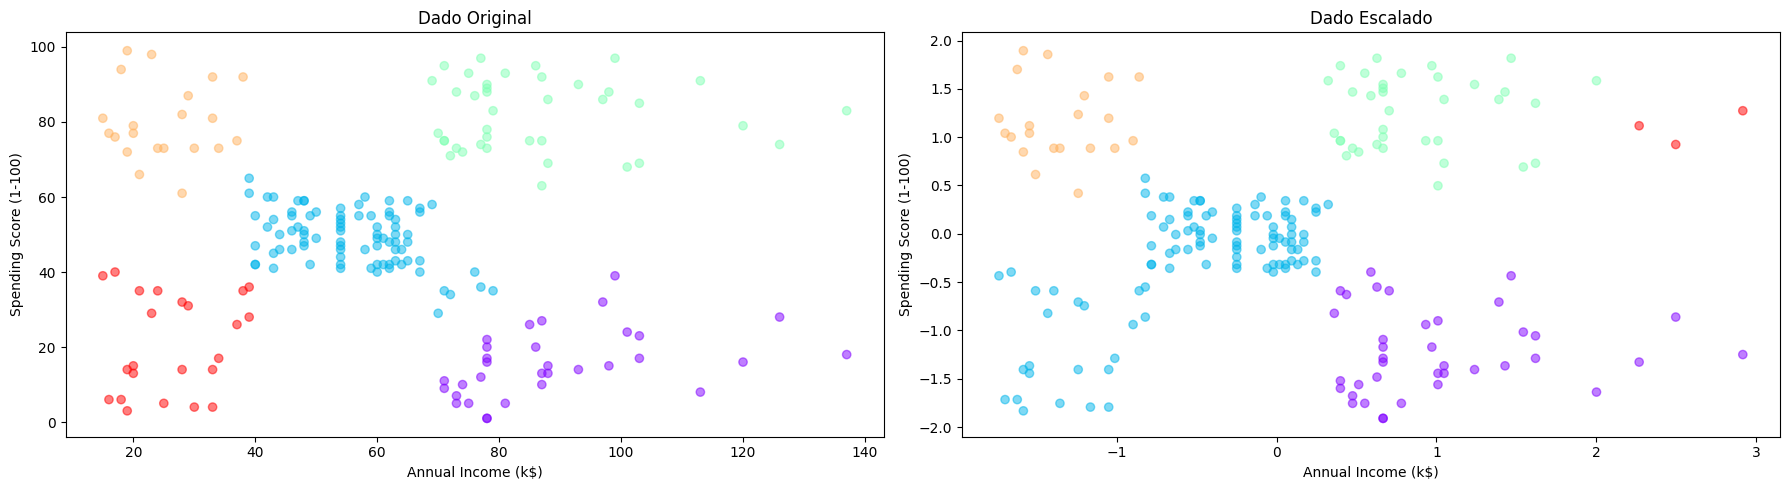

In [28]:
plt.subplot(1, 2, 1)
plt.scatter(df[['Annual Income (k$)']], df[['Spending Score (1-100)']], c=agg_clustering_labels, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Original')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(X_scaler[:, 0], X_scaler[:, 1], c=agg_clustering_labels_scaler, alpha=0.5, cmap='rainbow') # type: ignore
plt.title('Dado Escalado')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.rcParams['figure.figsize'] = (18, 5)
plt.tight_layout()
plt.show()

## Validação

Tipos:
- Interna: Quanto bom foi o meu agrupamento?
- Externa: Como parecido estão os meus dois algoritmos comparados?

### Avaliando o Desempenho dos Algoritmos

### Tipo Externo:

Usando o **Adjusted Rand Index**

Compara o desempenho quando forem fornecidos datasets com labels geradas de forma aleatória. Quando essas labels estão muito diferente, o valor se aproxima de 0, o que sugere um resultado negativo, ou seja, clusters não próximos.

In [29]:
adjusted_rand_score(best_kmeans_labels, dbscan_labels)

0.7151933782093212

In [30]:
adjusted_rand_score(agg_clustering_labels, gmm_labels)

0.20784771687231673

In [31]:
adjusted_rand_score(mean_shift_labels, spectral_clustering_labels)

0.0026913440677893952

### Avaliando a Métrica de Índice de Calinski-Harabasz

O *Índice de Calinski-Harabasz* é crucial para entender a separação e compacidade dos clusters. Ele avalia a distância entre os centros dos clusters, buscando maximizá-la. Valores mais altos indicam clusters bem definidos e distintos entre si. Portanto, ao interpretar os resultados, um índice de Calinski-Harabasz maior sugere uma clusterização mais precisa.

---

### Avaliando a Métrica de Coeficiente de Silhueta

O *Coeficiente de Silhueta* é uma métrica valiosa para medir a semelhança média de um ponto com os outros pontos no mesmo cluster e a dissimilaridade média com os pontos em clusters diferentes. Varia de -1 a +1, onde valores mais próximos de +1 indicam uma clusterização mais apropriada. Um coeficiente de silhueta mais alto indica que os pontos estão bem agrupados e longe dos outros clusters.

---

### Avaliando a Métrica de Índice de Davies-Bouldin

O *Índice de Davies-Bouldin* é essencial para medir a similaridade média entre cada cluster e o cluster mais similar a ele. Isso é feito considerando tanto a distância intra-cluster quanto a distância entre clusters. Um valor mais baixo indica uma melhor clusterização. Portanto, ao interpretar os resultados, um índice de Davies-Bouldin menor sugere uma clusterização mais precisa.



In [32]:
score = calinski_harabasz_score(X, best_kmeans_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, best_kmeans_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, best_kmeans_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 247.35899338037282
Coeficiente de silhueta: 0.553931997444648
Índice de Davies-Bouldin: 0.5725628995597085


In [33]:
score = calinski_harabasz_score(X, dbscan_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, dbscan_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, dbscan_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 42.23595546342582
Coeficiente de silhueta: 0.36328873885121793
Índice de Davies-Bouldin: 2.1435552011106336


In [34]:
score = calinski_harabasz_score(X, gmm_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, gmm_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, gmm_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 1.8721440415550006
Coeficiente de silhueta: 0.0681332125455244
Índice de Davies-Bouldin: 6.648544271614505


In [35]:
score = calinski_harabasz_score(X, mean_shift_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, mean_shift_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, mean_shift_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 2062.208021390374
Coeficiente de silhueta: 0.2233285978361716
Índice de Davies-Bouldin: 0.15192327773121106


In [36]:
score = calinski_harabasz_score(X, spectral_clustering_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, spectral_clustering_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, spectral_clustering_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 86.49690263120269
Coeficiente de silhueta: 0.3834954980710284
Índice de Davies-Bouldin: 0.856947307854549


In [37]:
score = calinski_harabasz_score(X, agg_clustering_labels)
print("Índice de Calinski-Harabasz:", score)

silhouette_avg = silhouette_score(X, agg_clustering_labels)
print("Coeficiente de silhueta:", silhouette_avg)

davies_bouldin = davies_bouldin_score(X, agg_clustering_labels)
print("Índice de Davies-Bouldin:", davies_bouldin)

Índice de Calinski-Harabasz: 243.07142892964563
Coeficiente de silhueta: 0.5529945955148897
Índice de Davies-Bouldin: 0.5782207452369451
